In [7]:
%load_ext autoreload
%autoreload 2
#%env CUDA_VISIBLE_DEVICES=3


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Download packages if in Google Colab

In [8]:
colab_requirements = [
    "pip install librosa",
    "pip install noisereduce",
    "pip install soundfile",
    "pip install diffusers"
]

import sys, subprocess

def run_subprocess_command(cmd):
    # run the command
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    # print the output
    for line in process.stdout:
        print(line.decode().strip())

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    for i in colab_requirements:
        run_subprocess_command(i)
else: # do it anyway
    !pip install librosa
    !pip install noisereduce
    !pip install soundfile
    !pip install diffusers
    !pip install accelerate

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


  0%|          | 0/50 [00:00<?, ?it/s]

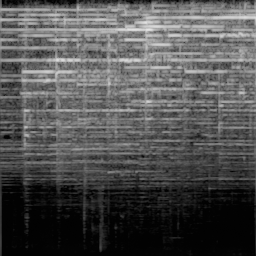

In [10]:
from IPython.display import Audio
from diffusers import DiffusionPipeline
import torch_directml
import torch

# hack for pytorch-ml on windows
dml = torch_directml.device()
#pipe = DiffusionPipeline.from_pretrained("teticio/audio-diffusion-ddim-256").to(dml) # dml switch here

device = "cuda" if torch.cuda.is_available() else "cpu"
#pipe = DiffusionPipeline.from_pretrained("teticio/audio-diffusion-ddim-256").to(device) # dml switch here
pipe = DiffusionPipeline.from_pretrained("teticio/audio-diffusion-ddim-256", provider="DmlExecutionProvider", low_cpu_mem_usage=True)
#pipe = StableDiffusionOnnxPipeline.from_pretrained("./stable_diffusion_onnx", provider="DmlExecutionProvider")
# alt? 
# pipe = OnnxStableDiffusionPipeline.from_pretrained("./stable-diffusion-v1-5", revision="onnx", provider="DmlExecutionProvider", device_map="auto")


output = pipe()
display(output.images[0])
display(Audio(output.audios[0], rate=pipe.mel.get_sample_rate()))

#### Test noise reduction algorithm and view steps of algorithm

In [11]:
import IPython
from scipy.io import wavfile
import noisereduce as nr
import soundfile as sf
from noisereduce.generate_noise import band_limited_noise
import matplotlib.pyplot as plt
import urllib.request
import numpy as np
import io
%matplotlib inline

### Load data

In [12]:
url = "https://raw.githubusercontent.com/timsainb/noisereduce/master/assets/fish.wav"
response = urllib.request.urlopen(url)
data, rate = sf.read(io.BytesIO(response.read()))
data = data

In [13]:
IPython.display.Audio(data=data, rate=rate)

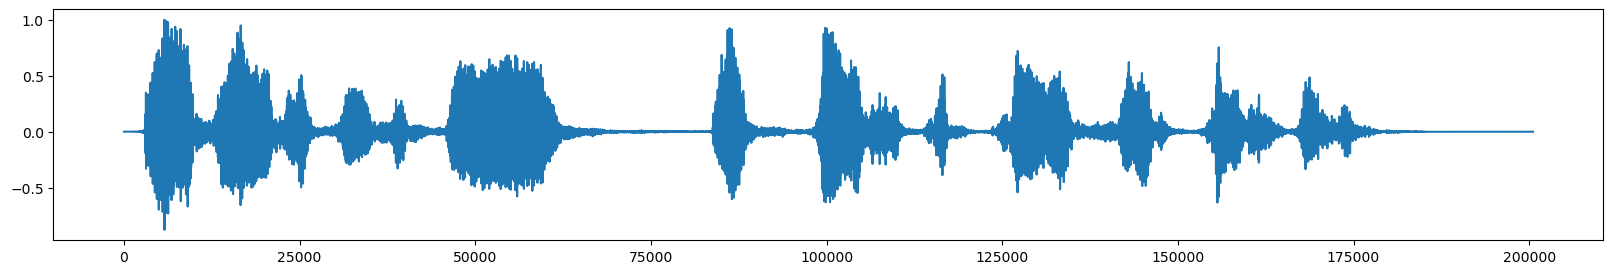

In [14]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(data)

### add noise

In [15]:
noise_len = 2 # seconds
noise = band_limited_noise(min_freq=2000, max_freq = 12000, samples=len(data), samplerate=rate)*10
noise_clip = noise[:rate*noise_len]
audio_clip_band_limited = data+noise

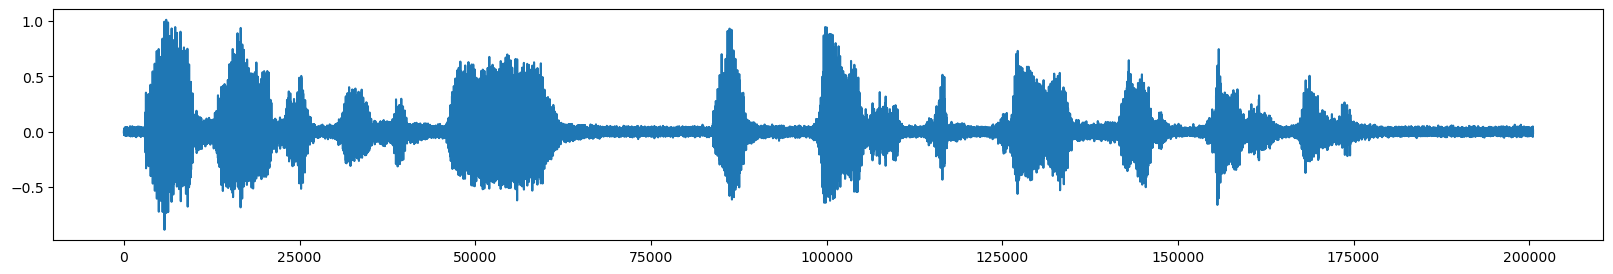

In [16]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(audio_clip_band_limited)

In [17]:
IPython.display.Audio(data=audio_clip_band_limited, rate=rate)

### Stationary remove noise

In [18]:
reduced_noise = nr.reduce_noise(y = audio_clip_band_limited, sr=rate, n_std_thresh_stationary=1.5,stationary=True)

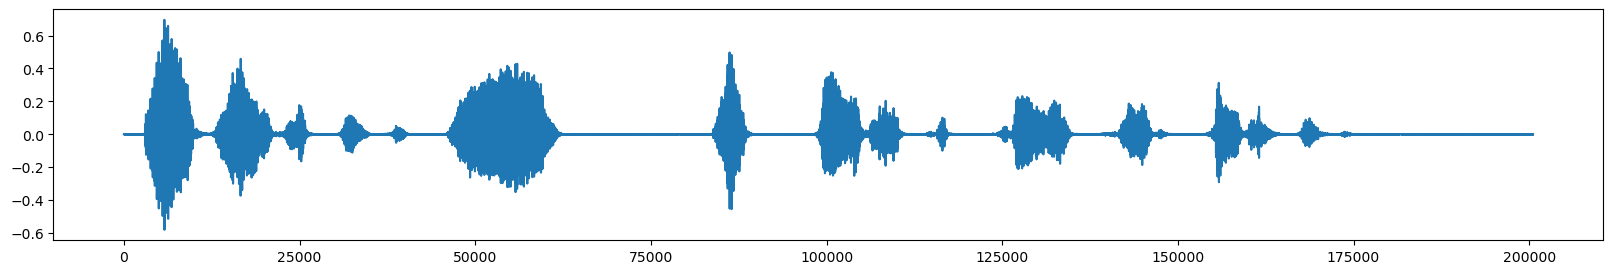

In [19]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(reduced_noise)

In [20]:
IPython.display.Audio(data=reduced_noise, rate=rate)

### Non-stationary noise reduction

In [21]:
reduced_noise = nr.reduce_noise(y = audio_clip_band_limited, sr=rate, thresh_n_mult_nonstationary=2,stationary=False)

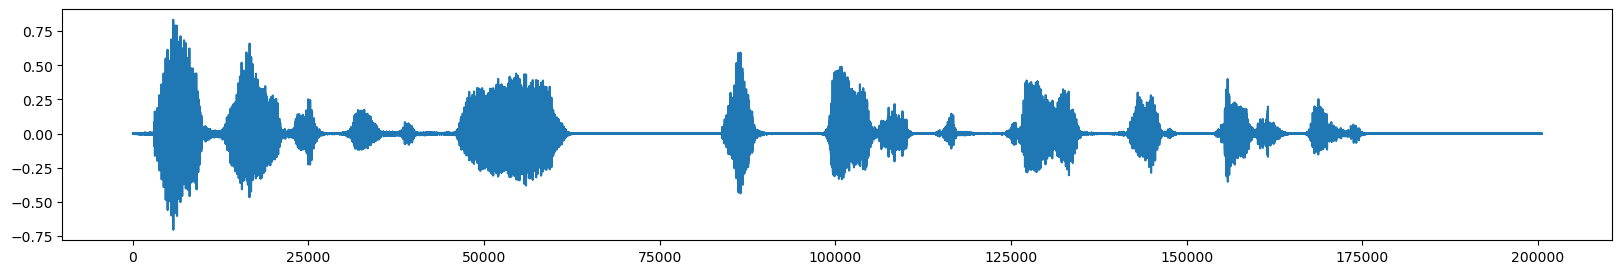

In [22]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(reduced_noise)

## A more difficult example 

In [23]:
url = "https://raw.githubusercontent.com/timsainb/noisereduce/master/assets/cafe_short.wav"
response = urllib.request.urlopen(url)
noise_data, noise_rate = sf.read(io.BytesIO(response.read()))

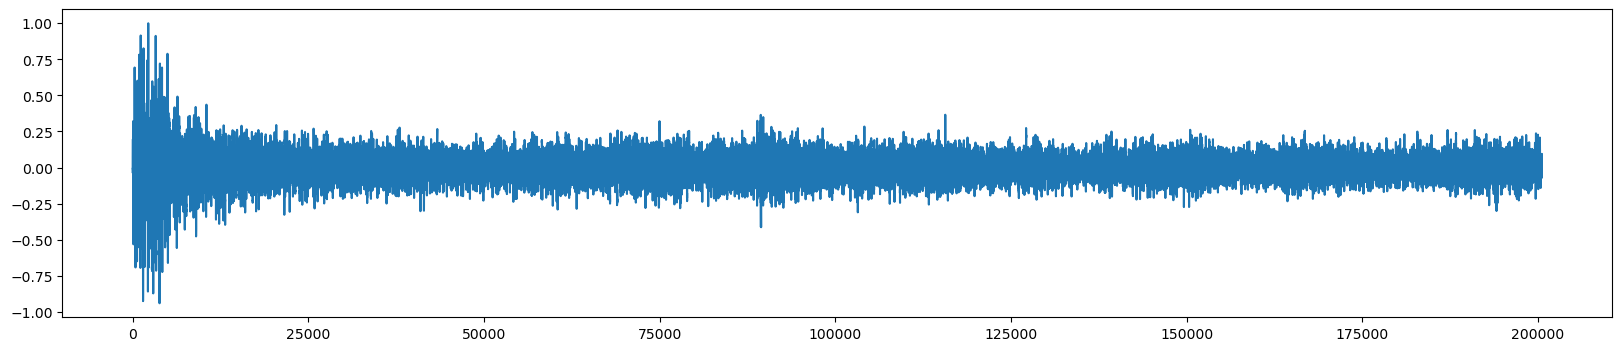

In [24]:
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(noise_data)

In [25]:
IPython.display.Audio(data=noise_data, rate=noise_rate)

### add noise to data

In [26]:
snr = 2 # signal to noise ratio
noise_clip = noise_data/snr
audio_clip_cafe = data + noise_clip

### plot noisy data

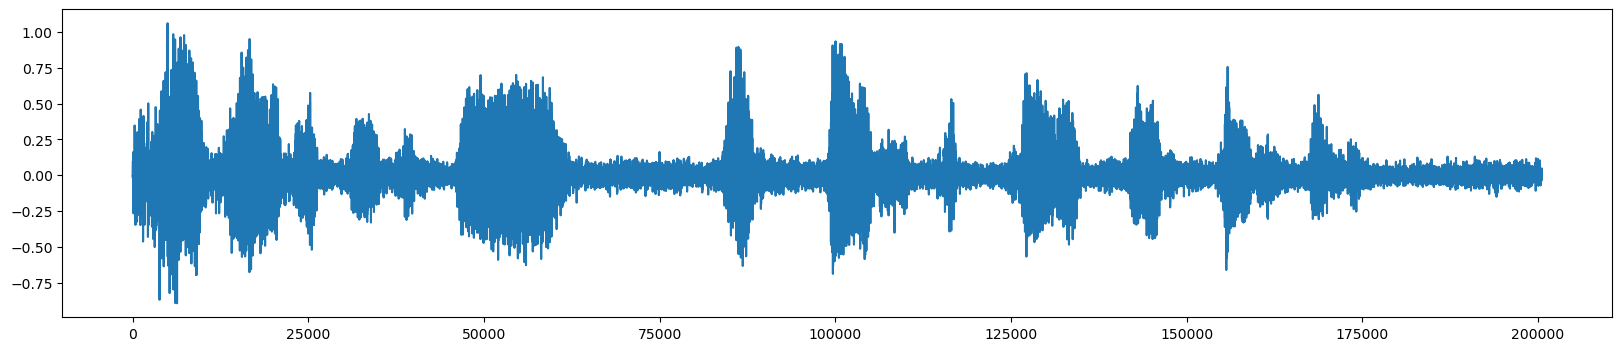

In [27]:
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(audio_clip_cafe)
IPython.display.Audio(data=audio_clip_cafe, rate=noise_rate)

### Stationary remove noise

In [28]:
reduced_noise = nr.reduce_noise(y = audio_clip_cafe, sr=rate, y_noise = noise_clip, n_std_thresh_stationary=1.5,stationary=True)

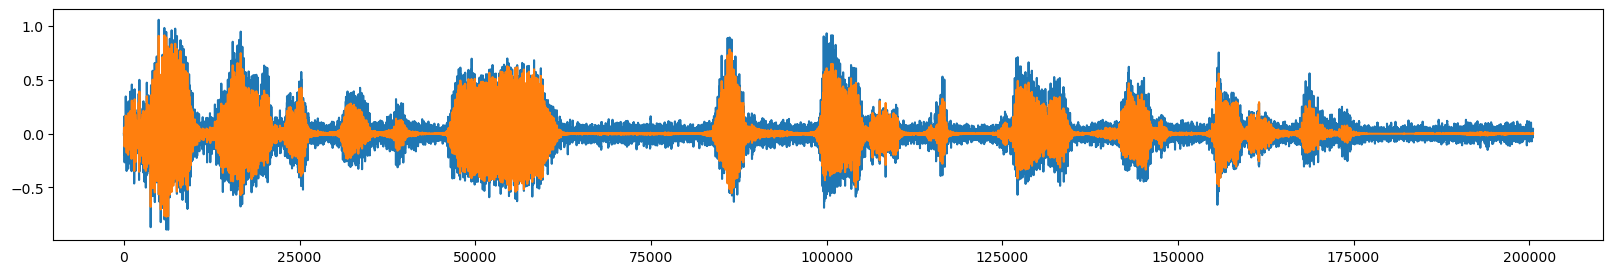

In [29]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(audio_clip_cafe)
ax.plot(reduced_noise)

In [30]:
IPython.display.Audio(data=reduced_noise, rate=rate)

### Non-stationary noise reduction

In [31]:
reduced_noise = nr.reduce_noise(y = audio_clip_cafe, sr=rate, thresh_n_mult_nonstationary=2,stationary=False)

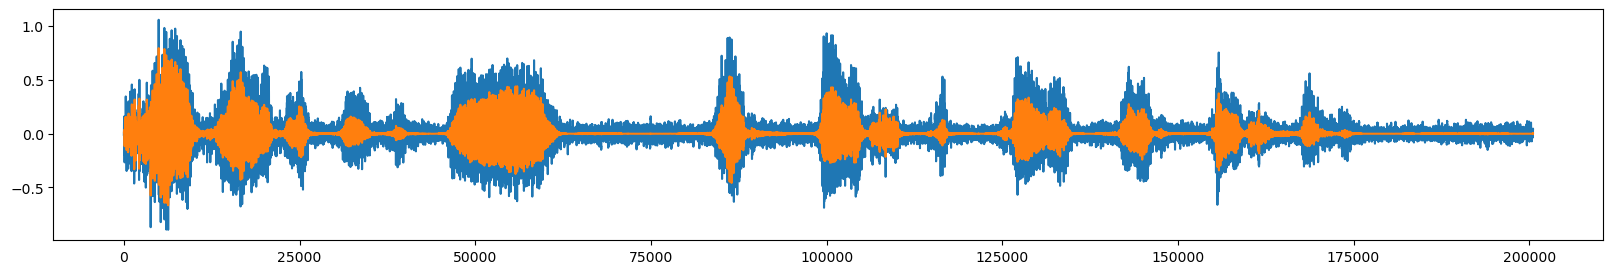

In [32]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(audio_clip_cafe)
ax.plot(reduced_noise, alpha = 1)
IPython.display.Audio(data=reduced_noise, rate=rate)

In [33]:
IPython.display.Audio(data=reduced_noise, rate=rate)

### ensure that noise reduction does not cause distortion when prop_decrease == 0

In [34]:
noise_reduced = nr.reduce_noise(y=data, sr=rate, prop_decrease=0, stationary=False)

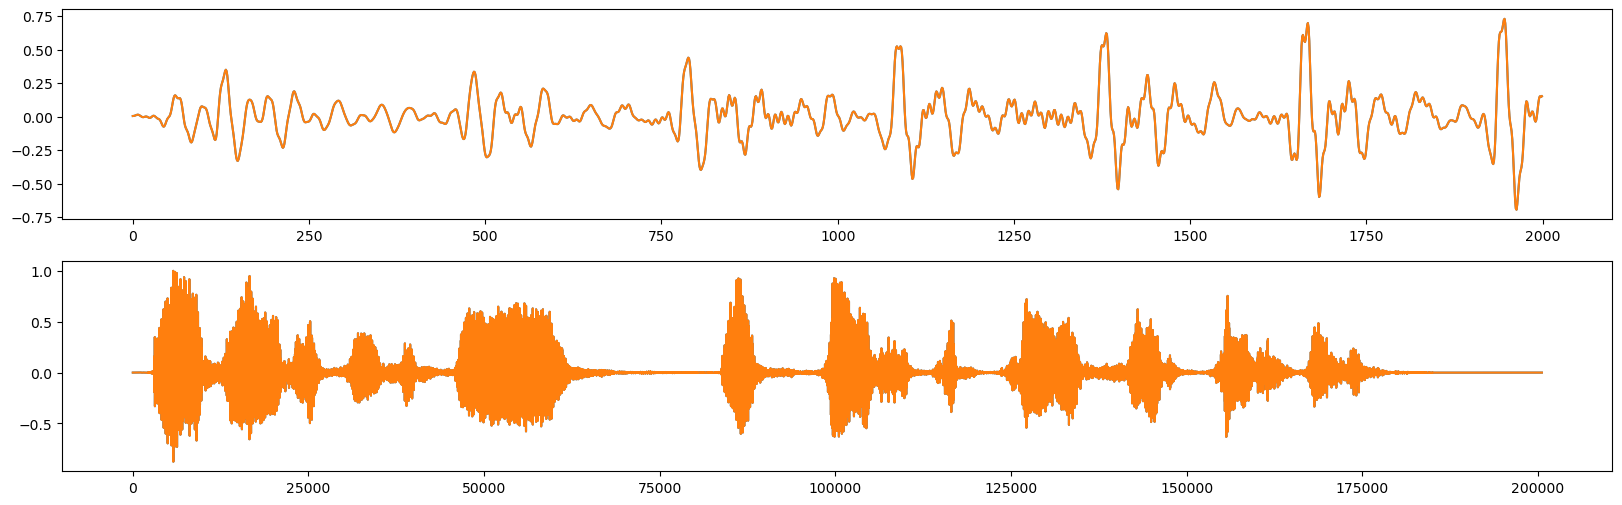

In [35]:
fig, axs = plt.subplots(nrows=2, figsize=(20,6))
axs[0].plot(data[3000:5000])
axs[0].plot(noise_reduced[3000:5000])
axs[1].plot(data)
axs[1].plot(noise_reduced)

In [36]:
noise_reduced = nr.reduce_noise(y=data, sr=rate, prop_decrease=0, stationary=False)

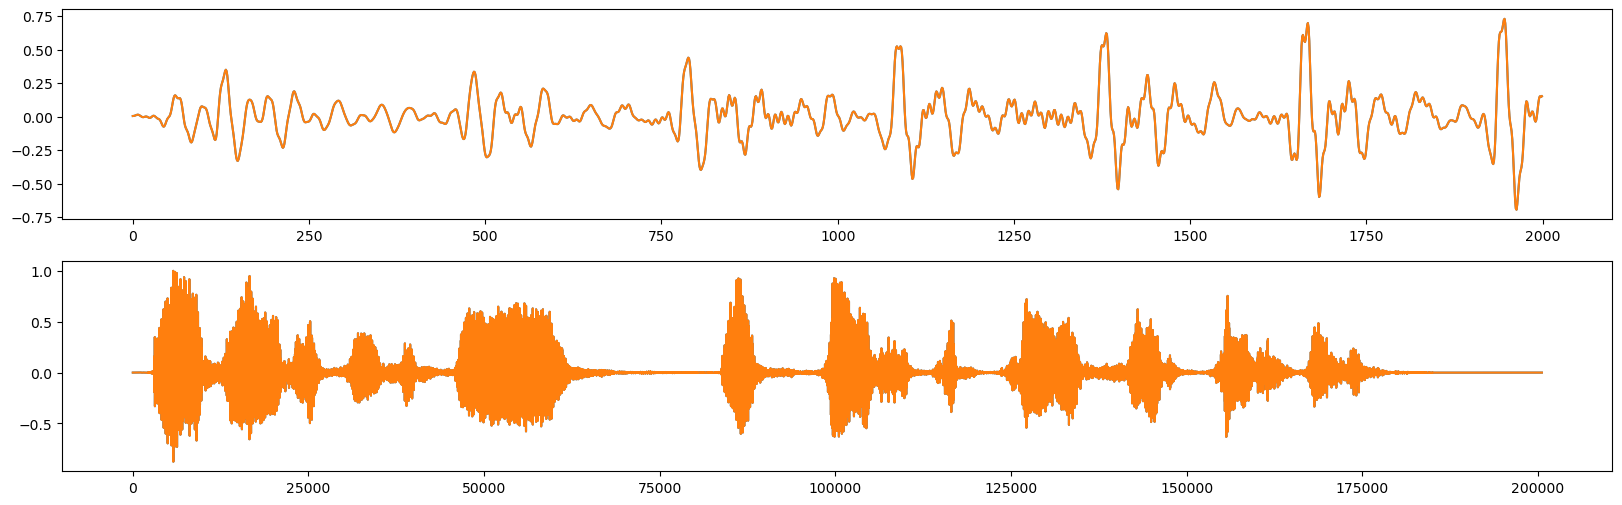

In [37]:
fig, axs = plt.subplots(nrows=2, figsize=(20,6))
axs[0].plot(data[3000:5000])
axs[0].plot(noise_reduced[3000:5000])
axs[1].plot(data)
axs[1].plot(noise_reduced)

### Reduce noise over batches in parallel on long signal

In [38]:
long_data = np.tile(data, 10)
len(long_data)/rate

45.47437641723356

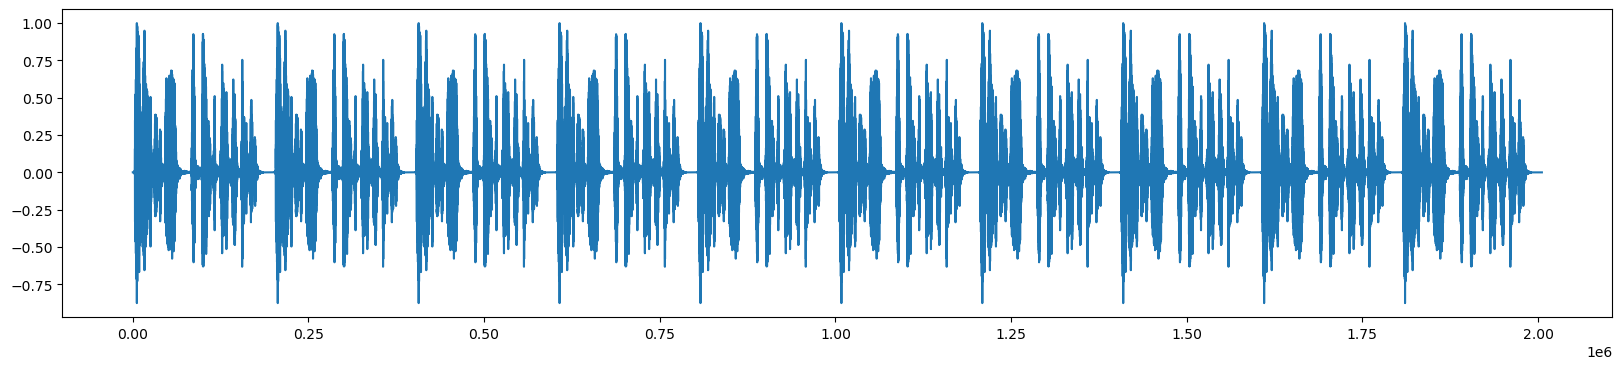

In [39]:
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(long_data)

In [40]:
noise = band_limited_noise(min_freq=2000, max_freq = 12000, samples=len(long_data), samplerate=rate)*10
audio_clip_band_limited = long_data+noise

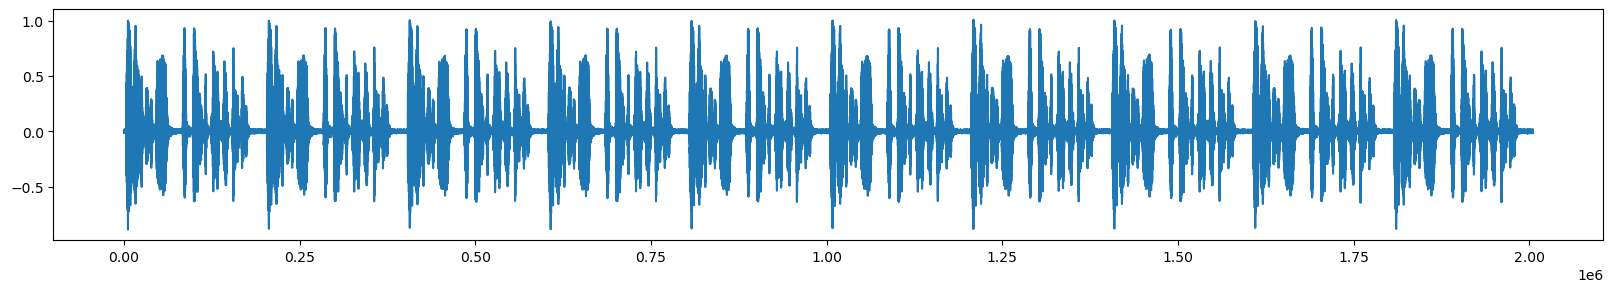

In [44]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(audio_clip_band_limited)

In [45]:
reduced_noise = nr.reduce_noise(
    y=audio_clip_band_limited,
    sr=rate,
    thresh_n_mult_nonstationary=2,
    stationary=False,
    n_jobs=2,
)

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

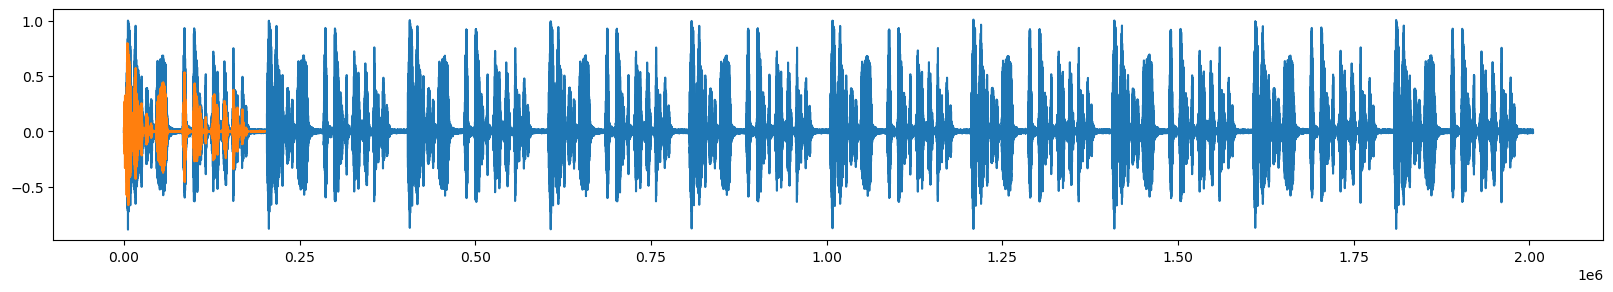

In [46]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(audio_clip_band_limited)
ax.plot(reduced_noise)

In [48]:
reduced_noise = nr.reduce_noise(
    y=audio_clip_band_limited,
    sr=rate,
    thresh_n_mult_nonstationary=2,
    stationary=True,
    #n_jobs=2,
)

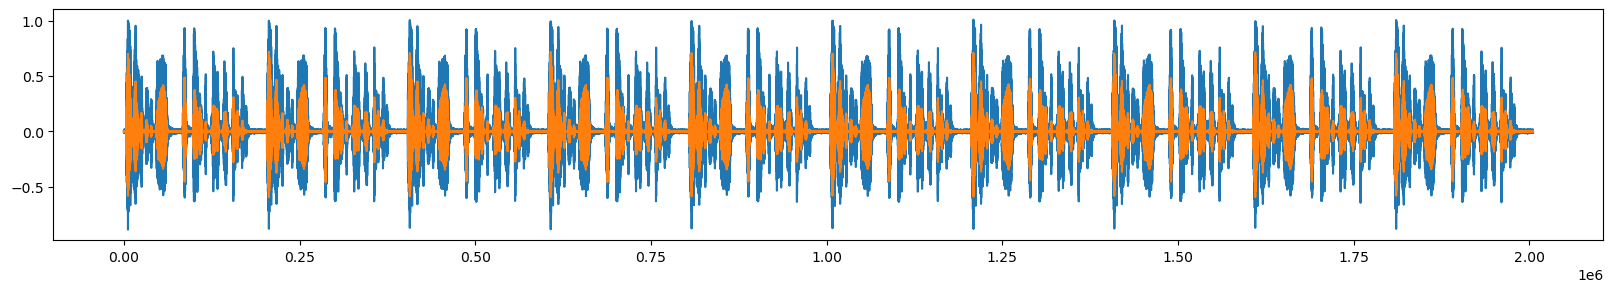

In [49]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(audio_clip_band_limited)
ax.plot(reduced_noise)

### Reduce noise on only a subset of a long clip

In [50]:
from noisereduce.noisereduce import SpectralGateStationary

In [51]:
sg = SpectralGateStationary(
    y = data,
    sr = rate,
    y_noise=None,
    prop_decrease=1.0,
    time_constant_s=2.0,
    freq_mask_smooth_hz=500,
    time_mask_smooth_ms=50,
    n_std_thresh_stationary=1.5,
    tmp_folder=None,
    chunk_size=600000,
    padding=30000,
    n_fft=1024,
    win_length=None,
    hop_length=None,
    clip_noise_stationary=True,
    use_tqdm=False,
    n_jobs=1,
)

In [52]:
subset_noise_reduce = sg.get_traces(start_frame = 10000, end_frame = 20000)

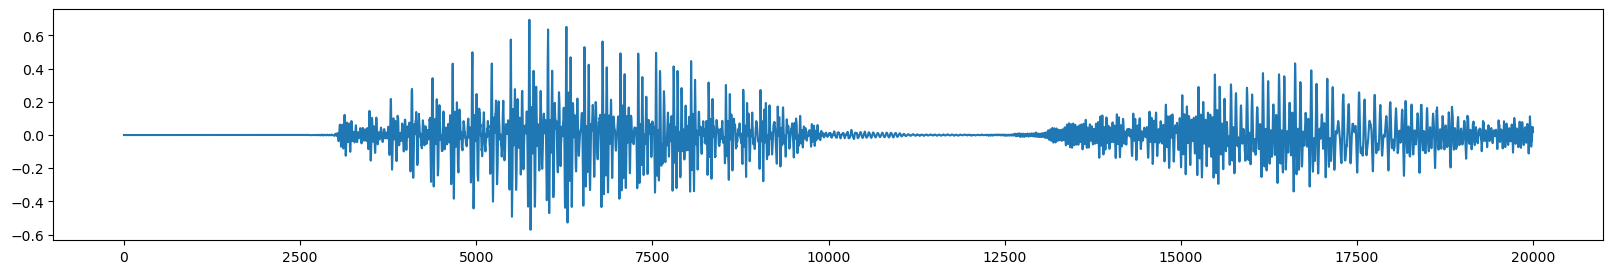

In [53]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(subset_noise_reduce)

## Multichannel noise

In [54]:
audio_clip_cafe_2_channel = np.vstack([audio_clip_cafe, audio_clip_cafe])
audio_clip_cafe_2_channel.shape

(2, 200542)

In [55]:
reduced_noise = nr.reduce_noise(y = audio_clip_cafe_2_channel, sr=rate, n_std_thresh_stationary=1.5,stationary=True)

In [56]:
reduced_noise.shape

(2, 200542)

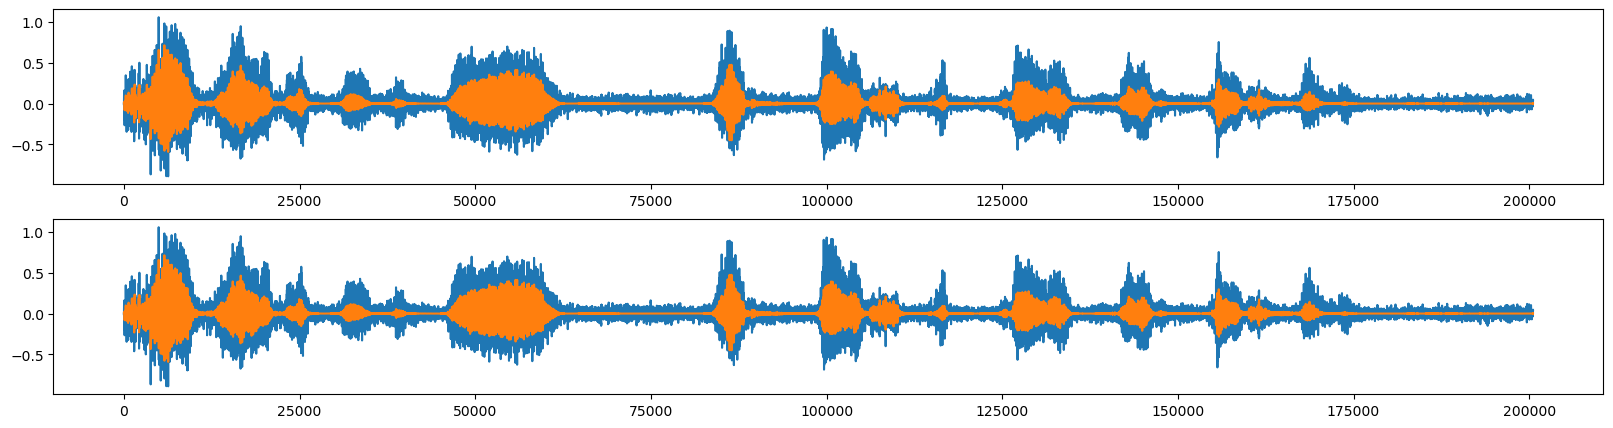

In [57]:
fig, axs = plt.subplots(nrows= 2, figsize=(20,5))
axs[0].plot(audio_clip_cafe_2_channel[0])
axs[1].plot(audio_clip_cafe_2_channel[1])

axs[0].plot(reduced_noise[0])
axs[1].plot(reduced_noise[1])

In [59]:
IPython.display.Audio(data=reduced_noise, rate=rate)

In [60]:
reduced_noise = nr.reduce_noise(y = audio_clip_cafe, sr=rate, thresh_n_mult_nonstationary=2,stationary=False)

In [61]:
reduced_noise.shape

(200542,)

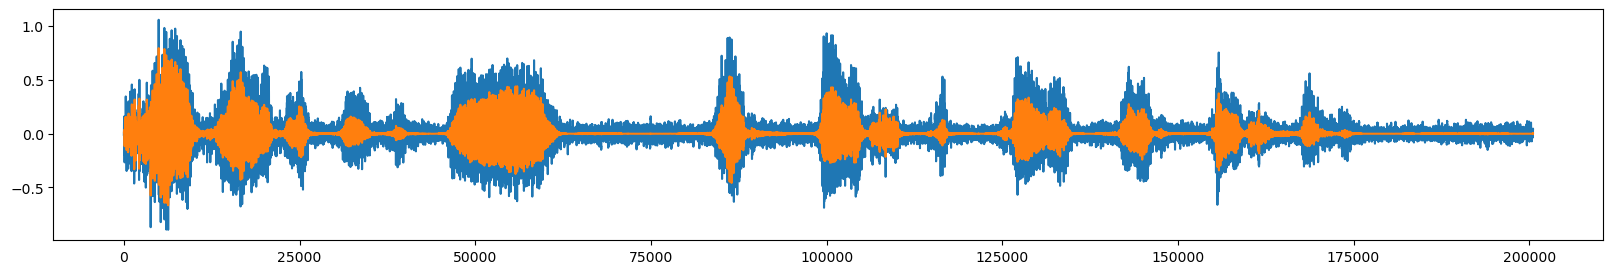

In [62]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(audio_clip_cafe)
ax.plot(reduced_noise, alpha = 1)
IPython.display.Audio(data=reduced_noise, rate=rate)